In [1]:
import pandas as pd
from datetime import datetime, timedelta, time
import numpy as np
from collections import defaultdict
import seaborn as sns
import sys


print("Python Version:", sys.version)
print("Pandas Version:", pd.__version__)
print("Numpy Version:", np.__version__)
print("Seaborn Version:", sns.__version__)

main_path = '/Users/PC/Desktop/Insight/MTASafety'

Python Version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Pandas Version: 0.24.2
Numpy Version: 1.16.2
Seaborn Version: 0.9.0


In [5]:
raw = pd.read_csv(main_path + '/RiderData/Turnstile.csv', low_memory=False)

In [6]:
# Renaming the columns
df = raw.rename(columns=lambda x: x.strip().lower())

# Concatenating date and time and convert to datetime object
df['datetime'] = df['date'] + ' ' + df['time']
df['datetime_clean'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in df['datetime']]

In [7]:
# Adding some additional date-part columns
df['year'] = [x.year for x in df['datetime_clean']]
df['weekday'] = df[['datetime_clean']].apply(lambda x: datetime.strftime(x['datetime_clean'], '%A'), axis=1)

In [12]:
# Creating group ID for distinct turnstiles
df['group'] = df['c.a'].astype(str) + \
                df['unit'].astype(str) + \
                df['scp'].astype(str) + \
                df['station'].astype(str)  + \
                df['line.name'].astype(str) + \
                df['division'].astype(str) + \
                df['year'].astype(str)
                
# Mapping 'group' string to integer id     
groups = set(df['group'])


def groups_dict(groups):
    group_dict = defaultdict(int)
    for i in enumerate(list(groups)):
        group_dict[i[1]]= i[0]

    return group_dict

group_id_dict = groups_dict(groups)

df['group_id'] = [group_id_dict[x] for x in df['group']]

In [13]:
df.head()

,unnamed: 0,c.a,unit,scp,station,line.name,division,date,time,description,entries,exits,datetime,datetime_clean,year,weekday,group,group_id
0,1,A002,R051,02-05-00,59 ST,NQR456W,BMT,06/07/2019,00:00:00,REGULAR,130,0,06/07/2019 00:00:00,2019-06-07,2019,Friday,A002R05102-05-0059 STNQR456WBMT2019,2948
1,2,A002,R051,02-03-01,59 ST,NQR456W,BMT,06/07/2019,00:00:00,REGULAR,1130231,1743202,06/07/2019 00:00:00,2019-06-07,2019,Friday,A002R05102-03-0159 STNQR456WBMT2019,6793
2,3,A002,R051,02-03-03,59 ST,NQR456W,BMT,06/07/2019,00:00:00,REGULAR,5767050,6618923,06/07/2019 00:00:00,2019-06-07,2019,Friday,A002R05102-03-0359 STNQR456WBMT2019,17347
3,4,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/07/2019,00:00:00,REGULAR,6311419,1415507,06/07/2019 00:00:00,2019-06-07,2019,Friday,A002R05102-00-0159 STNQR456WBMT2019,7023
4,5,A002,R051,02-03-04,59 ST,NQR456W,BMT,06/07/2019,00:00:00,REGULAR,7146869,3705404,06/07/2019 00:00:00,2019-06-07,2019,Friday,A002R05102-03-0459 STNQR456WBMT2019,8026


In [15]:
# Creating station ID for distinct stations
df['station_line'] = df['station'].astype(str) + \
                df['line.name'].astype(str)

In [16]:
# Sorting values by group id and date to find diff in turnstile counts from prev row
df.sort_values(['group_id','datetime_clean'], inplace=True)
df.reset_index(drop=True)

def find_diff_prev_row(df_series_col):
    col_array = np.array(df_series_col)
    col_array_shifted = shift(col_array, 1, cval=np.NaN)
    col_diff = abs(col_array - col_array_shifted)

    return col_diff


df['entries_diff'] = find_diff_prev_row(df['entries'])
df['exit_diff'] = find_diff_prev_row(df['exits'])

In [20]:
# Identifying first rows for each group partition to use as mask when setting invalid values to nan
def find_first_rows_groups(df_series_col):
    col_array = np.array(df_series_col)
    col_array_shifted = shift(col_array, 1, cval=np.NaN)
    first_row_mask = col_array != col_array_shifted

    return first_row_mask


df['first_row_group'] = find_first_rows_groups(df['group_id'])

# Making entries_diff and exit_diff nan when first row in group or negative value
df.loc[df['first_row_group'], 'entries_diff'] = None
df.loc[df['entries_diff'] < 0, 'entries_diff'] = None

df.loc[df['first_row_group'], 'exit_diff'] = None
df.loc[df['exit_diff'] < 0, 'exit_diff'] = None

In [22]:
df.to_csv(main_path + '/RiderData/Turnstile3.csv')

In [5]:
df=pd.read_csv(main_path + '/RiderData/Turnstile3.csv', low_memory=False)

In [6]:
#Creating a function to identify outliers
def find_outliers(df_series, multiple_IQR):
    """
    For a series of numerical values, remove the zeros and identify the upper outliers 
    to return a mask for all outliers in series
    """
    non_zeros = df_series.replace(0, None)
    
    adjusted_IQR = (non_zeros.quantile(.75) - non_zeros.quantile(.25)) * multiple_IQR
    outlier_lim = non_zeros.quantile(.75) + adjusted_IQR
    print(outlier_lim)
    
    outliers = [True if x > outlier_lim else False for x in df_series]
    
    outlier_count = sum(outliers)
    all_data_count = len(df_series)
    print('{} outliers identified: {} of all data'.format(outlier_count, round(outlier_count/all_data_count,6)))
    
    return outliers

In [7]:
#Locating Outliers
print('Entries Outliers')
df['entries_outlier'] = find_outliers(df['entries_diff'], 5)

print('\n Exit Outliers')
df['exit_outlier'] = find_outliers(df['exit_diff'], 5)

Entries Outliers
1454.0
150135 outliers identified: 0.006396 of all data

 Exit Outliers
974.0
362310 outliers identified: 0.015436 of all data


In [8]:
#Removing Outliers
print('All Data Len:', len(df))

clean_df = df.loc[(~df['entries_outlier'])].copy()
print('Excluding Outliers Len:', len(clean_df))

print('Keeping', round(len(clean_df)/len(df), 6))

All Data Len: 23472102
Excluding Outliers Len: 23321967
Keeping 0.993604


In [9]:
print('Null entry diffs', clean_df.entries_diff.isnull().sum())
print('Null exit diffs', clean_df.exit_diff.isnull().sum())
print('Clean Data len:', len(clean_df))

Null entry diffs 19357
Null exit diffs 19357
Clean Data len: 23321967


In [10]:
#Dropping NAs
clean_df.dropna(subset = ['entries_diff', 'exit_diff'], how='any', inplace=True)

print('Null entry diffs', clean_df.entries_diff.isnull().sum())
print('Null exit diffs', clean_df.exit_diff.isnull().sum())
print('Clean Data len:', len(clean_df))

Null entry diffs 0
Null exit diffs 0
Clean Data len: 23302610


In [14]:
thrown_away = len(df) - len(clean_df)
print("I'm throwing away {} data points - about {} of the total".format(thrown_away, round(thrown_away/len(df), 4)))

I'm throwing away 169492 data points - about 0.0072 of the total


In [28]:
clean_df['DateTime2'] = pd.to_datetime(clean_df['datetime_clean'])

In [29]:
clean_df['week'] = [x.isocalendar()[1] for x in clean_df['DateTime2']]
clean_df['hour'] = [x.hour for x in clean_df['DateTime2']]

In [30]:
#Creating hourgroups and weekday numbers
def timebin(hour):
    if hour ==0:
        return 6
    if hour <= 4:
        return 1
    if hour <=8:
        return 2
    if hour <=12:
        return 3
    if hour <= 16:
        return 4
    if hour <= 20:
        return 5
    if hour <= 24:
        return 6
    
hourgroups = {6:'8pm - 12am', 
              1: '12am - 4am', 
              2:'4am - 8am', 
              3:'8am - 12pm', 
              4:'12pm - 4pm', 
              5:'4pm - 8pm'}

wkdaynbr = {'Friday': 5,
 'Monday': 1,
 'Saturday': 6,
 'Sunday': 0,
 'Thursday': 4,
 'Tuesday': 2,
 'Wednesday': 3}

In [31]:
clean_df['timegroup'] = clean_df['hour'].apply(timebin)
clean_df['timegroupstr'] = clean_df['timegroup'].map(hourgroups)
clean_df['wkdaynbr'] = clean_df['weekday'].map(wkdaynbr)

In [34]:
clean_df.to_csv(main_path + '/RiderData/Turnstile6.csv')

In [32]:
# Find daily average entries per station
stations_day = clean_df.groupby(['station_line', 'date']).sum()
stations_day.reset_index(inplace=True)

daily_avg = stations_day.groupby('station_line')['entries_diff'].mean()
daily_avg.sort_values(ascending=False, inplace=True)

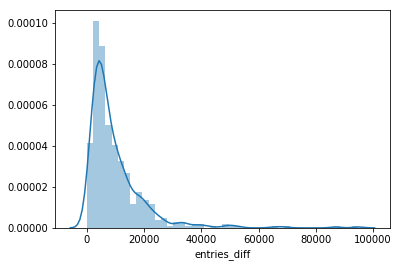

In [33]:
sns.distplot(daily_avg, hist=True, kde=True);

In [38]:
daily_avg.head(30)

station_line
GRD CNTRL-42 ST4567S           94761.816850
34 ST-HERALD SQBDFMNQRW        86919.732601
42 ST-PORT AUTHACENQRS1237W    68946.161172
34 ST-PENN STAACE              65571.279609
TIMES SQ-42 ST1237ACENQRSW     52813.310134
FULTON ST2345ACJZ              51032.507937
14 ST-UNION SQLNQR456W         49097.866911
FLUSHING-MAIN7                 48725.406593
JKSN HT-ROOSVLTEFMR7           43398.568460
59 ST COLUMBUSABCD1            40596.909646
CANAL STJNQRZ6W                40096.532357
PATH NEW WTC1                  38513.103268
86 ST456                       37284.018315
72 ST123                       34840.942613
34 ST-PENN STA123ACE           34328.652015
W 4 ST-WASH SQABCDEFM          33961.796093
59 ST456NQRW                   32944.746032
JAY ST-METROTECACF             32083.326007
96 ST123                       32071.938950
47-50 STS ROCKBDFM             31627.927961
LEXINGTON AV/53EM6             29010.266178
42 ST-BRYANT PKBDFM7           27376.240196
57 ST-7 AVNQRW     